# MONDRIAN $k$-ANONIMISATION ALGORITHM

-------------------
<font size="2">Текущая версия ноутбука Jupiter представляет собой адаптацию версиии [Nuclearstar/K-anonymity](https://github.com/Nuclearstar/K-Anonymity) для GOOGLE COLAB. Основные функции представлены на Python 3 с использованием структур  `pandas` и средств визуализации `matplotlib`)</font>

$\qquad$ В данном ноутбуке исследуются несколько алгоритмов "k-anonymity" 

Расчет выполняется аналогично вычислениям AMNEZIA на основании кластеризации одинаковых строк (классов эквивлентности) для расчета и обсепечения анонимизации исходного набора данных.

Для большей информации смотрите: 

- [Модель расчета риска: презентация АБД](https://app.box.com/s/r59vlvmonzpsu1xi46tk8wn1svt39h2o)
- [Рекомендации по методам обезличивания: рабочая версия АБД](https://app.box.com/s/hvgwq7py6b59slpkalu9fzidvppib8rd)
- [k-Anonymity: A Model For Protecting Privacy. Latanya Sweeney](https://epic.org/privacy/reidentification/Sweeney_Article.pdf)
- [Mondrian - Multidimensional k-Anonymity](https://www.utdallas.edu/~muratk/courses/privacy08f_files/MultiDim.pdf)

## 1 ВВЕДЕНИЕ

## 1.1 Основные понятия

#### 1.1.1 Модель $k$-anonimity и риски повторной идентификации
<p align="justify">$\qquad$ <b>k-anonymity</b> -модель, которая позволяет снижать риски повторной идентификации путем объединения атрибутов в группы, описывающие не менее $k$ людей. Предположим, что имеется набор из  $N$ строк/записей. Каждая запись состоит из  $D$ полей/атрибутов, из которых $X_i$ ($i \in [0,D]$) не содержат конфиденциальной информации (non-sensitive) о физическом лице, примером таких атрибутов является возраст, пол, почтовый код и т.п. Однако,  это подмножество атрибутов может в совокупности указывать на конкретное лицо в данной группе.Такие атрибуты, в совокупности указывающие на конкретную персону называются <b>квази-идентификаторами</b> ("quasi-identifiers"), а их комбинация - <b>супер-идентификатор</b> ("super-identifier"), который может указывать на уникальную персону в достаточно большом наборе данных (т.е. комбинация пола, возраста и почтового кода ведет к выделению отдельной личности). </p>
     
<p align="justify">$\qquad$ В дополнение подразумевается, что кроме квази-идентификаторов набор данных может содержать некоторые данные напрямую указывающие на личность (например, ИНН) - <b>прямые идентификаторы</b> ("direct-identificatotrs"), а также по крайней мере один атрибут представляющий чувствительную информацию - например, уровень дохода ("income") или сведения о болезни. Модель нацелена на защиту этой чувствительной информации. В рамках такой защиты записи подвергаются методам обезличивания - <b>обобщению</b> ("generalization") или подавлению ("suppression"), цель этих методов разрушить информацию таким образом, чтобы снизить количество строк с одинаковыми квази-атрибутами (так называемые классы эквивалентности). Объем минимального класса эквивалентности (количество записей с одинаковыми занчениями квази-идентификаторов) обратно пропорционален вероятности риска повторной идентификации и может служить числовой характеристикой метода.</p> 


<p align="justify">$\qquad$ Применение методов обезличивания ведет к тому, что полезная информация в обезличенных наборах данных становится менеее качественной - для измерения уровня этого качества используются специальные метрики <b>расчета полезности</b> ("utility"). Суть модели - нахождение баланса между риском повторной идентификации с одной стороны и полезностью набора  данных - с другой.</p>

<p align="justify">$\qquad$ В первом приближении модель k-anonymity  требует выделения квази-идентификаторов ("QID") и вычисления для них <b>размеров классов-эквивалентности</b>  $k$ строк/физических лиц, затем итерационное применение методов обезличивания (включающих подавление строк или ячеек, обобщение значений), между которыми следует анализ получившегося набора и уточнение параметров методов обезличивания. В результате это защищает отдельных людей, сводя к минимому информацию об отдельном человеке, оставляя злоумышленнику ("adversary") только информацию о принадлежности данного человека к определенной группе.  Хотя получающийся набор не является точным, он все еще годится для целей анализа и построения моделей машинного обучения. В ряде случаев надо решать не только проблему обезличивания, но и иного подхода к идентификации, например, для решения задач, в которых обобщенные данные не могут использоваться напрямую.</p>

### 1.2 Алгоритм Мондриана для расчета k-anonymity

<p align="justify">$\qquad$ Процесс обезличивания, в общих терминах описываемый выше при достижении $k$- anonimity (и, возможно, $l$-diversity или $t$-близости, является сложной вычислительной задачей (<b>NP-hard problem</b>). В тоже время существет несколько практических алгоритмов, дающих приемлемые результаты ("good enough"), например, с использованием так называемого "жадного" поиска (#"greedy search techniques"). </p>

<p align="justify">Одним из возможных методов является <b>алгоритм Мондриана</b> ("Mondrian" algorithm, название вытекает из 2D представления групп, напоминаюших картины Пита Мондриана - Piet Mondrian).</p>
<p align="justify">$\qquad$ Алгоритм Мондриана - метод анонимизации данных сверху вниз, предложенный Кристеном Лефевром в 2006 году, относится к жадным (greedy) алгоритмам. В рамках этого метода категориальные данные преобразуются в числовые и применяются иерархии обобщения (в строгом случае это называется <i>Basic_Mondrian</i>)</p>


<p align="justify">Для применения алгоритма все атрибуты должны быть преобразованы в числовые или категориальные значения, так что мы можем измерить диапазон ("span") заданного атрибуа данных  $X_i$.</p>

#### 1.2.1 Базовая идея алгоритма

<p align="justify">$\qquad$ Предполагаем, что мы имеем набор данных, организованный в виде строк и столбцов (атрибутов), которые можно представить в виде $[QID, SA]$. Здесь $QID$ _ квази-идентификаторы, а $SA$ - чувствительные атрибуты (<i>Sensitive Attributes</i>). Первоначальная информация организована так, что каждому $QID$ соответсвует свой $SA$ и легко с помощью этих квазиидентификаторов можно повторно идентифицировать  физическое лицо и соотнести его с чувствительной (конфиденциальной) информацией. Однако, если появляется возможность разбить исходный набор на кластеры (партиции, кластеры), так что квази-идентификаторы совпадают и образуют единую группу $QID^*$, которой соответсвуют несколько $SA$, то соотнести конкретный $SA$ с исходным $QID$ не предоставляется возможности.</p>


<img src="http://intelligentobjectsio.ipage.com/dgtworld/images/AnonimizedDataSet_4.png" style="height:10px">QID кластеризация</img>

<p align="justify">$\qquad$ На практике необработанные (не обезличенные) наборы данных не обладают свойством $k$- anonimity, при котором одному обобщенному $QUID^*$ соответсвует несколько $SA_i$</p>
<p align="justify">$\qquad$ В связи с этим исходный набор подвергается обработке:</p>
<li> <b>PARTITION</b>: Исходный набор делится на k-группы (каждая содержит не менее k-записей), используя $kd$-дерево так, чтобы группа имела схожие $QID_i$;</li>
<li> <b>GENERALIZATION:</b> группа обобщается таким образом, чтобы каждая запись имела одинаковый $QID^*$</li>

<p align="justify">$\qquad$  $kd$-дерево - специальная геометрическая структура данных, позволяющая разбить пространство на "меньшие части" посредством сечения плоскостями ($K=3$), прямыми ($K=2$)</p>

<img src="https://cloud.githubusercontent.com/assets/3848789/25949052/c6ab3fce-3688-11e7-99ea-cde7bccd8684.png">$kd$-tree</img>



### 1.3 Парционирование (выделение групп/классов эквивалентности)

<p align="justify">$\qquad$ Для разделения данных на k-anonymous групп алгоритм требует выполнения следующих шагов (напоминающих метод половинного деления):</p>

>  
1. Инициализируем конечный массив  групп/классов эквивалентности (изначально пустых) $P_{finished} = \{\}$.
2. Инициализируем рабочий массив, который содержит единственную группу - весь набор данных $P_{working} = \{\{1, 2,\dots ,N\}\}$.
3. Выполняем цикл: пока в рабочем наборе есть хоть одна группа (partition) - извлекаем ее и выполняем следующие действия:
  * Вычисляем относительные частоты (spans) для всех атрибутов - столбцов в выделенной группе.
  * Сортируем плученные столбцы по их частоте в порядке убывания и выполняем итерацию для каждого столбца:
      * Разбиваем полученную группу - по каждому столбцу, используя медиану в качестве точки разделения ("split point").
      * Проверяем, соответсвуют ли полученные данные критериям k-анонимизации (или иным критериям)- в том числе с оценкой вероятности повторной идентификации.
      * Если да, то добавляем в массив групп два овых набора и выходим из цикла. Если нет - проводим дальнейшие преобразования.
  * Если ни по одному из столбцов не получилось корректно разделить набор - добавляем такой набор в массив конечных наборов.
4. Возвращаем набор конечны групп
>

## 2 РАСЧЕТ С ИСПОЛЬЗОВАНИЕМ $k$-Anonymity
$\qquad$ Ниже предлагается применение метода к определенному набору!

### 2.1 Подготовка к расчетам - загрузка данных


In [320]:
# Для выполнения расчетов изпользуем библиотека Pandas, облегчающая работу с категориальными данными
import pandas as pd
from collections import Counter
import math
import matplotlib.pyplot as plt
import numpy as np

# Для версии Colab используем Google Drive вместо локальной ссылки на данные

PATH_TO_DATA = "data/lake_data_v.1.23.xlsx"  # Используйте для локальной версии
SHEET = "A1"

In [321]:
# Массив атрибутов/столбцов, поскольку файл данных не содержит заголовка (as the file doesn't contain any headers)
names = (
    'LastName','FirstName','MiddleName',
    'BirthDate','Sex','MargStatus',
    'Nationality','SNILS','BornPlace',
    'Account','AccDate','AccCloseDate',
    'Currency','TurnPerDay','AcBallance',
    'AcLastDate','TxDate','TxSum','TxPlace'
)

# Выделим дополнительно категориальные данные (C-Data) из представленных выше атрибутов
categorical = set((
     names
))
df = pd.read_excel(PATH_TO_DATA, sheet_name=SHEET, engine = 'openpyxl');# Загружаем основной набор данных

In [322]:
df.head(2)

,ID,LastName,FirstName,MiddleName,BirthDate,Sex,MargStatus,Nationality,SNILS,BornPlace,Account,AccDate,AccCloseDate,Currency,TurnPerDay,AcBallance,AcLastDate,TxDate,TxSum,TxPlace
0,1,Матвеев,Георге,Ахтямвич,17/09/1971,1`,0`,0`,448-266-814 51`,2`,737915314246`,22/04/2019,04/09/2022,1`,343.62`,3248.14`,30/01/2021,2021-01-30T06:54,706.12`,"Смоленский пассаж,Смоленская площадь_ д. 3."
1,2,Григорьева,Наиля,Алавна,13/05/1969,0`,1`,0`,356-900-894 21`,1`,641508292499`,04/03/2019,02/03/2022,0`,4868.03`,41766.93`,23/06/2019,2019-06-23T05:06,52139.93`,"Митинский,Пятницкое шоссе, д. 18."


In [323]:
QI = ['Account','TxDate','AcBallance','BirthDate','BornPlace', 'AccDate','AccCloseDate']

In [324]:
def k_anonymous(data, columns):
  ## Возьмите фрейм данных, верните значение k-anonymity
  ## Агрегируйте по именам столбцов и возьмите ненулевой минимум каждой строки
  aggregrate = data.groupby(columns).count().apply(lambda x : set(x) - set({0}),axis = 1)
  aggregrate = aggregrate.apply(lambda x : 0 if x == set() else min(x))
  count = dict(Counter(aggregrate))
  sort_arg = sorted(set(aggregrate))[:5]
  dub_data = data["Account"].drop_duplicates()
  print(len(dub_data),len(data))
  print(dub_data)    
  return [[arg,round(count[arg]/len(aggregrate) * 100,3)] for arg in sort_arg]
k_anonymous = k_anonymous(df, QI)
for arg in k_anonymous:
    print(f' k-anonymity = {arg[0]}[{arg[1]}%]')

15963 55894
0        737915314246`
1        641508292499`
2        516480468224`
3        709273505871`
4        359789595669`
             ...      
55666    788214070842`
55689    569190031183`
55717    592371331804`
55803    503136895985`
55866    773948254927`
Name: Account, Length: 15963, dtype: object
 k-anonymity = 1[99.998%]
 k-anonymity = 2[0.002%]


In [325]:
for name in categorical:
    df[name] = df[name].astype('category')

### 2.2 Вспомогательные функции

#### 2.2.1 Расчет диапазонов значений атрибутов

<p align="justify">$\qquad$ Имплементация функции, которая  дает <b>диапазоны изменения</b> (spans) для всех атрибутов/столбцов набора -dataframe (max-min для числовых атрибутов, число различных значений для категориальных данных).</p>

In [326]:
def get_spans(df, partition, scale=None):
    """
    :param        df: дата-фрейм, для которого рассчитывается диапазон
    :param partition: группа/класс эквивалентности для которого рассчитывается диапазон (spans)
    :param     scale: масштаб парционирования для каждого столбца
                      (может отсутсвовать)
    :        returns: диапазоны (spans) для каждого изменения
    """
    spans = {}
    for column in df.columns:
        if column in categorical:
            span = len(df[column][partition].unique())
        else:
            span = df[column][partition].max()-df[column][partition].min()
        if scale is not None:
            span = span/scale[column]
        spans[column] = span
    return spans

In [327]:
full_spans = get_spans(df, df.index)
full_spans

{'ID': 55893,
 'LastName': 498,
 'FirstName': 300,
 'MiddleName': 396,
 'BirthDate': 7897,
 'Sex': 2,
 'MargStatus': 3,
 'Nationality': 4,
 'SNILS': 10687,
 'BornPlace': 7,
 'Account': 15963,
 'AccDate': 365,
 'AccCloseDate': 730,
 'Currency': 3,
 'TurnPerDay': 14799,
 'AcBallance': 15954,
 'AcLastDate': 1617,
 'TxDate': 53511,
 'TxSum': 51384,
 'TxPlace': 99}

#### 2.2.2 Функция Split

<p align="justify"> $\qquad$ Функция 'split' принимает dataframe, столбец и исходную группу/раздел - возвращает пару разделов, которые образуются медианой на данном разделе</p>

In [328]:
def split(df, partition, column):
    """
    :param        df: Исходный dataframe
    :param partition: Исходный раздел (partition), который пробуем разбить
    :param    column: Определенный столбец, который определяет границы разбиения
    :        returns: Возвращаем кортеж с разделением исходного раздела (два раздела)
    """
    dfp = df[column][partition]
    if column in categorical:
        values = dfp.unique()
        lv = set(values[:len(values)//2])
        rv = set(values[len(values)//2:])
        return dfp.index[dfp.isin(lv)], dfp.index[dfp.isin(rv)]
    else:
        median = dfp.median()
        dfl = dfp.index[dfp < median]
        dfr = dfp.index[dfp >= median]
        return (dfl, dfr)

### 2.3 Реализация k-anonimity

In [329]:
def is_k_anonymous(df, partition, sensitive_column, k=3):
    """
    :param               df: Входной набор для которого осуществляется парционирование.
    :param        partition: Выделенная группа.
    :param sensitive_column: Наименование "чувствительного" атрибута/столбца
    :param                k: Уровень требуемого k-anonimity
    :returns               : Возвращает True если разбиение на партиции соответсвует k-anonimity, False - если достичь нужного уровня не удается.
    """
    if len(partition) < k:
        return False
    return True

def partition_dataset(df, feature_columns, sensitive_column, scale, is_valid):
    """
    :param               df: Набор для парционирования.
    :param  feature_columns: Список столбцов, по которым осуществляем парционирование внутри набора.
    :param sensitive_column: Наименование чувствительного атрибута, для которого определяем партицию -`is_valid` функция)
    :param            scale: Параметр парционирования для заданного столбца.
    :param         is_valid: Функция проверки партиции для заданного набора - возвращает True, если партиция корректна и False, если это не так.
    :returns               : Возвращает список годных партиций, покрывающих весь набор (dataframe).
    """
    finished_partitions = []
    partitions = [df.index]
    while partitions:
        partition = partitions.pop(0)
        spans = get_spans(df[feature_columns], partition, scale)
        for column, span in sorted(spans.items(), key=lambda x:-x[1]):
            lp, rp = split(df, partition, column)
            if not is_valid(df, lp, sensitive_column) or not is_valid(df, rp, sensitive_column):
                continue
            partitions.extend((lp, rp))
            break
        else:
            finished_partitions.append(partition)
    return finished_partitions


#### 2.3.1 Дизайн алгоритма Мондриана (парционирования)
$\qquad$ Применяем определенные ранее (см. 4.2) вспомогательные функции для разбиения на классы эквивалентности с использованием метрик $k$-Anonimity:

#### 2.3.2 Применение метода расчета к набору данных

<p align="justify"> $\qquad$Применение определенных выше функций к набору данных позволяет сформировать обезличенный набор. В целях упрощения ограничимся только двумя столбца для парционирования (простое применение алгоритма для полного набора может взять нескоько минут для полного набора) </p>

In [330]:
# В рамках текущей реализации используются два квази-идентификатора (feature_columns) и всего один чувствительный атрибут "income"
feature_columns = QI
sensitive_column = 'SNILS'
finished_partitions = partition_dataset(df, feature_columns, sensitive_column, full_spans, is_k_anonymous)

In [331]:
# в результате получаем число классов эквивалентности, созданных на наборе с заданным k = 3 we get the number of partitions that were created
len(finished_partitions)

15057

#### Выделение квази-идентификаторов на основе энтропии

In [332]:
ent_array = []
for qi in QI:
     counts = df.groupby(qi).size()
     total = counts.sum()
     entropy = 0
     for count in counts:
         probability = count / total
         entropy -= probability * math.log2(probability)
     ent_array.append(entropy)
     print(f'Entropy of {qi}: {entropy}')

Entropy of Account: 13.78276025987322
Entropy of TxDate: 15.683180332115915
Entropy of AcBallance: 13.78172408162582
Entropy of BirthDate: 12.571359559277397
Entropy of BornPlace: 2.668556381930658
Entropy of AccDate: 8.488015174946574
Entropy of AccCloseDate: 9.468069943812568


In [333]:
print(ent_array)

[13.78276025987322, 15.683180332115915, 13.78172408162582, 12.571359559277397, 2.668556381930658, 8.488015174946574, 9.468069943812568]


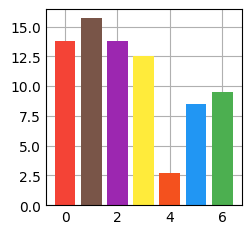

In [334]:
plt.style.use('_mpl-gallery')
y = ent_array
x = np.arange(len(y))
fig, ax = plt.subplots()

colors = ['#f44336', '#795548', '#9c27b0',
          '#ffeb3b', '#f4511e', '#2196f3',
          '#4caf50', '#ff9800']
ax.bar(x, y,  color=colors,  linewidth=0.7)
plt.show()

### 2.4 Визуализация парционирования

<p align="justify"> $\qquad$ Визуализация (с помощью matplotlib) парционирования может быть через определение прямоугольных  границ раздела по двум столбцам. Ожидаемый эффект - прямоугольники не перекрываются и покрывают весь набор<p>

In [335]:
import matplotlib.pylab as pl
import matplotlib.patches as patches

In [336]:
# Расчет индексов
def build_indexes(df):
    indexes = {}
    for column in categorical:
        values = sorted(df[column].unique())
        indexes[column] = { x : y for x, y in zip(values, range(len(values)))}
    return indexes

# Расчет координат
def get_coords(df, column, partition, indexes, offset=0.1):
    if column in categorical:
        sv = df[column][partition].sort_values()
        l, r = indexes[column][sv[sv.index[0]]], indexes[column][sv[sv.index[-1]]]+1.0
    else:
        sv = df[column][partition].sort_values()
        next_value = sv[sv.index[-1]]
        larger_values = df[df[column] > next_value][column]
        if len(larger_values) > 0:
            next_value = larger_values.min()
        l = sv[sv.index[0]]
        r = next_value
    # добавим небольшой сдвиг для улучшения представления
    l -= offset
    r += offset
    return l, r

# Расчет прямоугольников для соответсвующих классов эквивалентности
def get_partition_rects(df, partitions, column_x, column_y, indexes, offsets=[0.1, 0.1]):
    rects = []
    for partition in partitions:
        xl, xr = get_coords(df, column_x, partition, indexes, offset=offsets[0])
        yl, yr = get_coords(df, column_y, partition, indexes, offset=offsets[1])
        rects.append(((xl, yl),(xr, yr)))
    return rects

# Получение границ с учетом сдвигов
def get_bounds(df, column, indexes, offset=1.0):
    if column in categorical:
        return 0-offset, len(indexes[column])+offset
    return df[column].min()-offset, df[column].max()+offset

In [337]:
# Собственно расчеты для всех созданных партиций (классов эквивалентности)
indexes = build_indexes(df.astype(str))
column_x, column_y = feature_columns[:2]
rects = get_partition_rects(df, finished_partitions, column_x, column_y, indexes, offsets=[0.0, 0.0])

In [338]:
# Каждый прямоугольник представлен своими границами, нанесенными на общий прямоугольник исходного набора. Вот некоорые из них:
rects[:10]

[((281.0, 6008.0), (14966.0, 20253.0)),
 ((6077.0, 3540.0), (14230.0, 22273.0)),
 ((5125.0, 10169.0), (9522.0, 48333.0)),
 ((5878.0, 2777.0), (14308.0, 39317.0)),
 ((3757.0, 33359.0), (6536.0, 38145.0)),
 ((5381.0, 95.0), (14024.0, 46987.0)),
 ((10493.0, 4630.0), (11413.0, 49012.0)),
 ((6744.0, 1940.0), (12964.0, 32934.0)),
 ((5318.0, 11552.0), (14480.0, 42620.0)),
 ((6085.0, 23715.0), (13308.0, 46632.0))]

### 2.5 k-Anonymous Dataset

Определяем вспомогательные функции для аггрегации категориальных данных и числовых данных, а также собственно функцию построения нового набора данных

In [339]:
# Далее строим график
def plot_rects(df, ax, rects, column_x, column_y, edgecolor='black', facecolor='none'):
    for (xl, yl),(xr, yr) in rects:
        ax.add_patch(patches.Rectangle((xl,yl),xr-xl,yr-yl,linewidth=1,edgecolor=edgecolor,facecolor=facecolor, alpha=0.5))
    ax.set_xlim(*get_bounds(df, column_x, indexes))
    ax.set_ylim(*get_bounds(df, column_y, indexes))
    ax.set_xlabel(column_x)
    ax.set_ylabel(column_y)

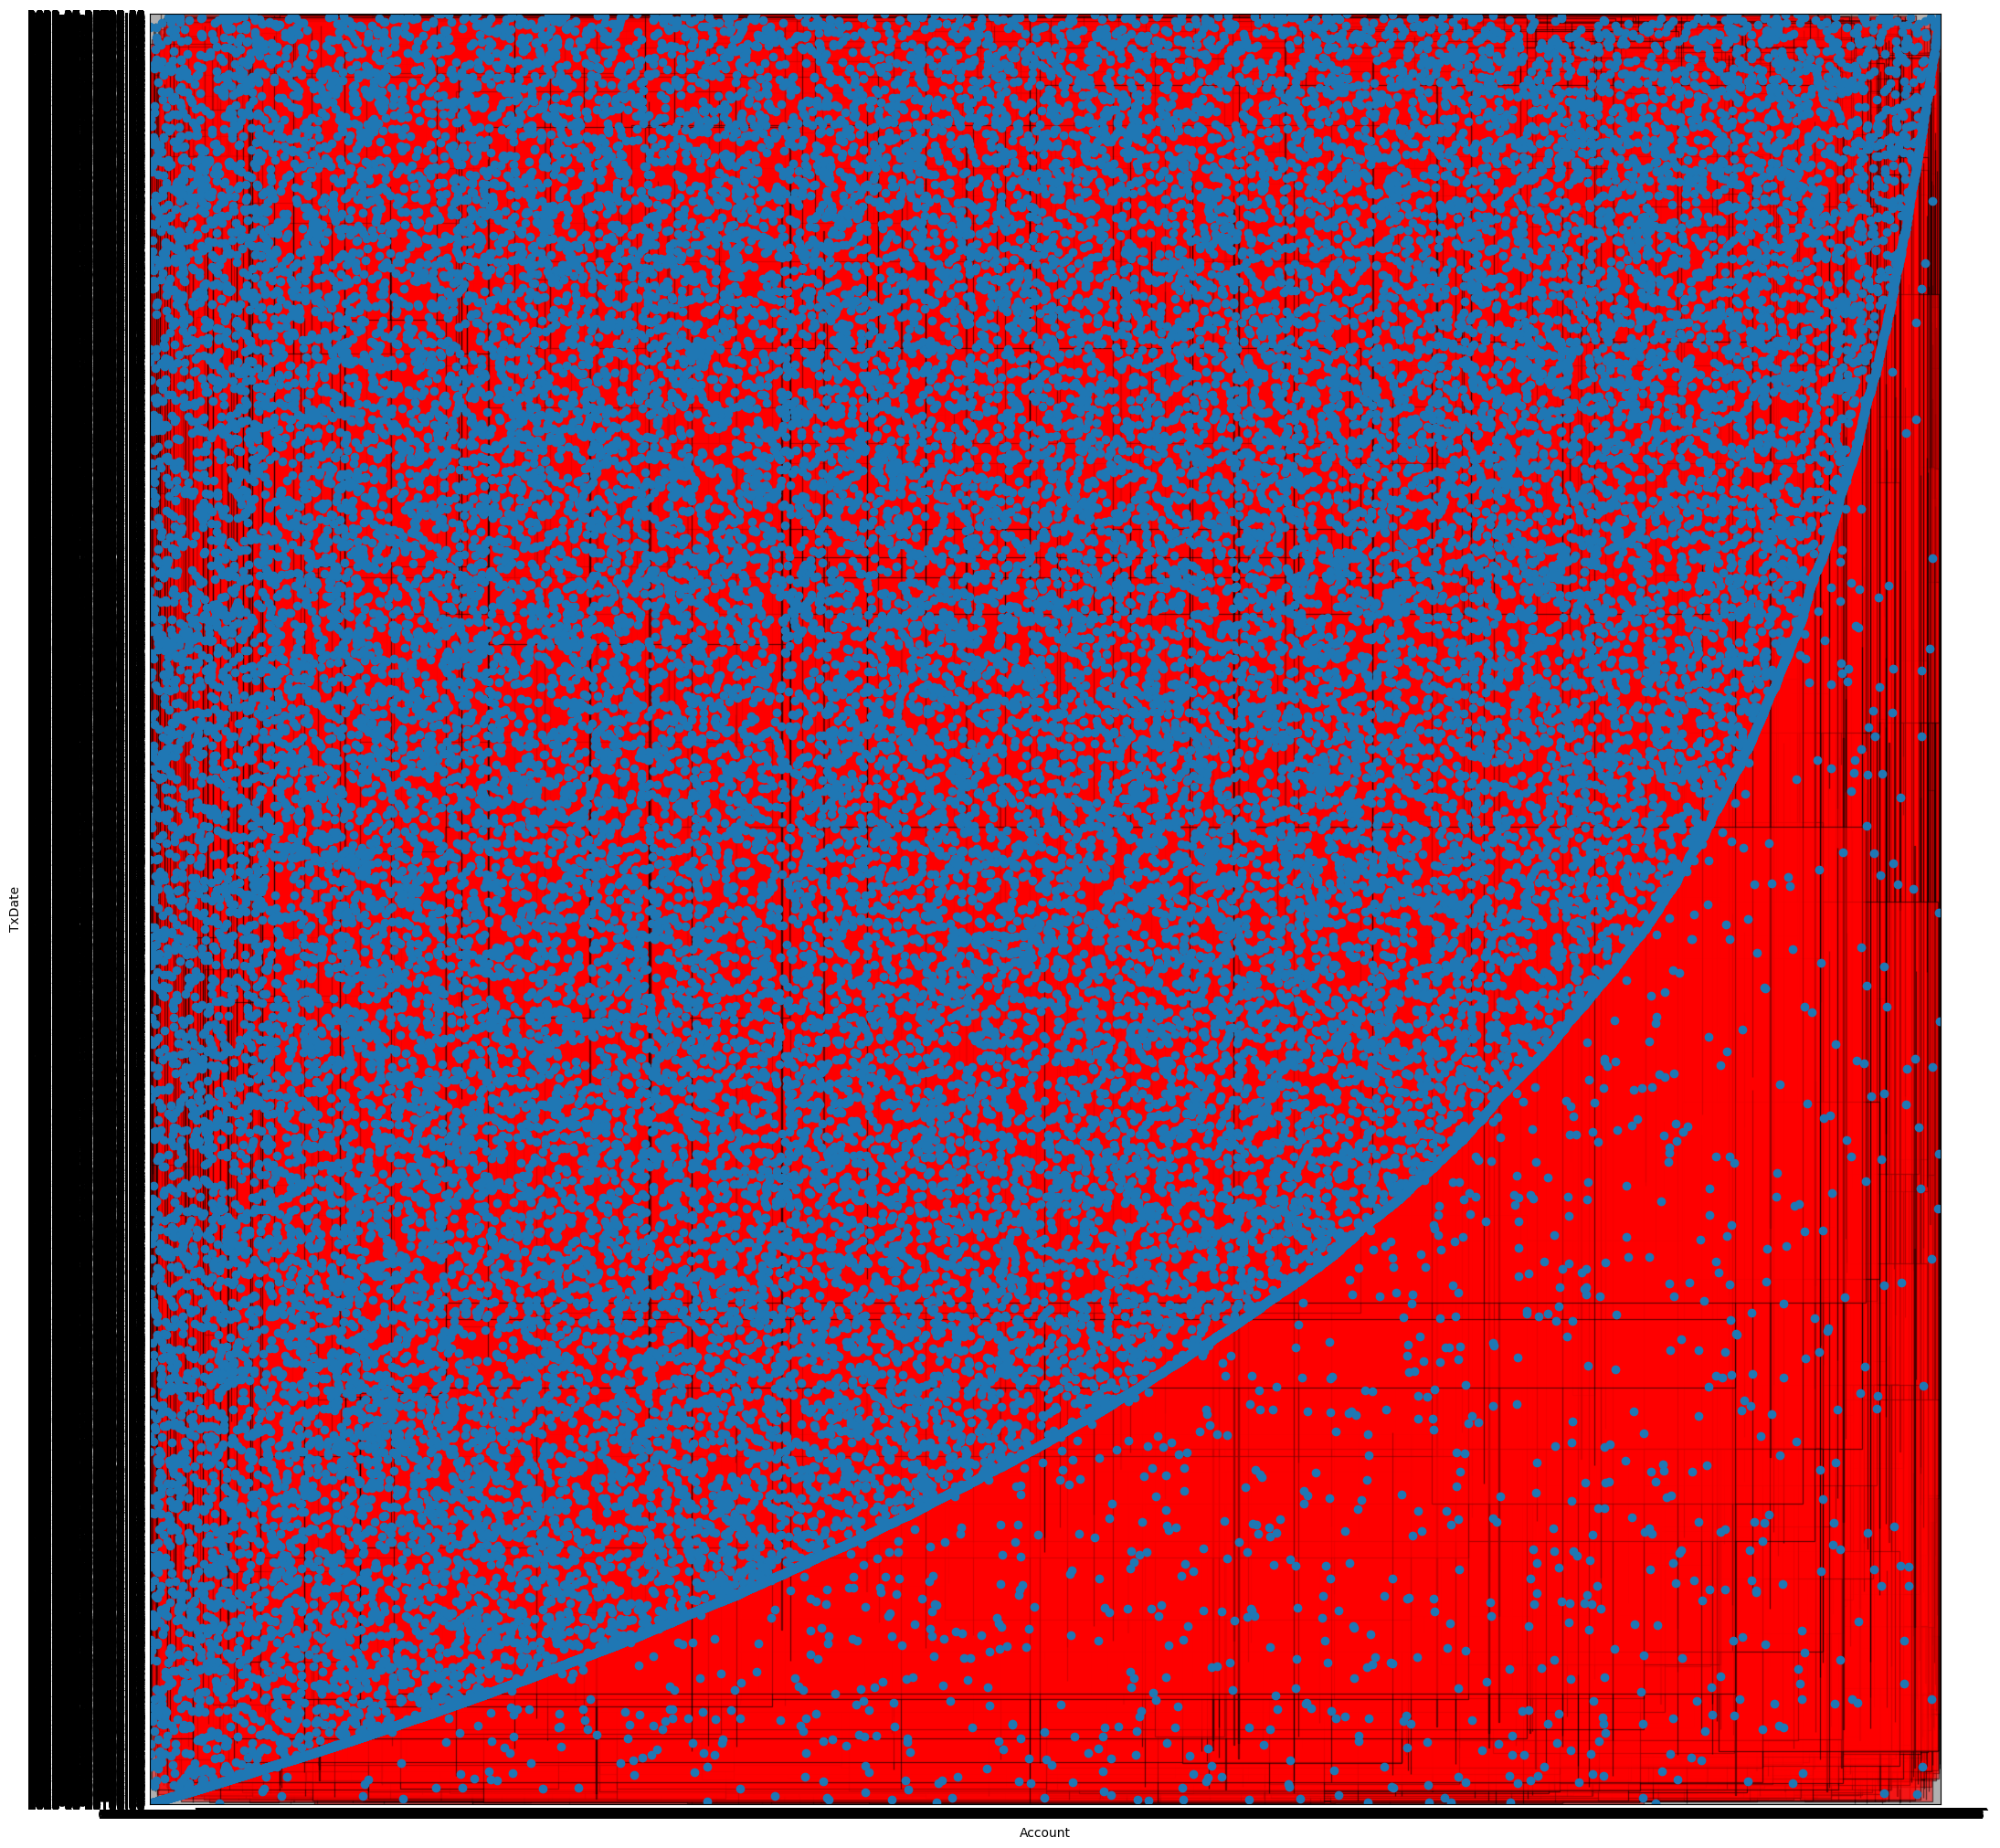

In [340]:
pl.figure(figsize=(20,20))
ax = pl.subplot(111)
plot_rects(df, ax, rects, column_x, column_y, facecolor='r')
pl.scatter(df[column_x], df[column_y])
pl.show()